# Notebook for slicing and plotting pre-reduced/reshaped GIWAXS

In [3]:
# Imports:
import pathlib, json, lmfit
from lmfit.models import PseudoVoigtModel, LinearModel, ExponentialModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
# Functions / misc:
def plot_reduced_image(sample='S1', log=True, save=False):
    """
    For quickly plotting reshaped GIWAXS from GIXSGUI-exported tif files
    """
    data = plt.imread(list(reducedPath.glob(f'*{sample}*'))[0])  # importantly, this uses global variable reducedPath
    data = data[:,:,0].copy()
    data.shape

    with np.errstate(divide='ignore'):
        data_log = np.log(data)

    # replace -inf's with zeros
    data_log[(data_log == -np.inf)] = 0

    if log:
        plt.imshow(data_log, origin='lower', extent=[-1.5,0.5,0,2])
    else:
        plt.imshow(data, origin='lower', extent=[-1.5,0.5,0,2])
    
    plt.title(f'{sample}_{sample_dict[sample]}')
    plt.xlabel('Qxy [1/A]')
    plt.ylabel('Qz [1/A]')
    plt.colorbar()
    
    if save==True:
        plt.savefig(savePath.joinpath(f'{sample_dict[sample]}_reduced.svg'))
    
    plt.show()


def linecut_plotter(dict1, dict2, sample, sample_dict, save=False, bot=1, cmap='cool'):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set(size_inches=(15,5))
    fig.suptitle(f'{sample}: {sample_dict[sample]} linecuts', size=16)
    
    # Choose specified color map, uses exec() to easily input the cmap chosen
    c = {}
    exec(f'c1 = plt.cm.{cmap}(np.linspace(0,1,len(IP_OOP_dict)))', None, c)
    exec(f'c2 = plt.cm.{cmap}(np.linspace(0,1,len(data_dict)))', None, c)
    c1, c2 = c['c1'], c['c2']

    for i, key in enumerate(dict1):
        q = dict1[key][:,0]
        I = dict1[key][:,1]
        ax1.plot(q, I, label=key, c=c1[i])

        # print(data_dict[key])

    for i, key in enumerate(dict2):
        q = dict2[key][:,0]
        I = dict2[key][:,1]
        ax2.plot(q, I, label=key, c=c2[i])

    for ax in (ax1,ax2):
        ax.set(yscale='log', ylim=(3))
        ax.legend()

    ax1.set_ylim(bottom=bot)
    ax2.set_ylim(bottom=bot)

    ax1.set(xlabel='Q [1/A]', ylabel='Intensity')
    ax2.set(xlabel='Q [1/A]', ylabel='Intensity')
    
    if save==True:
        plt.savefig(savePath.joinpath(f'{sample_dict[sample]}.svg'))
    plt.show()


def intensity_at(q_norm):
    print(f'Intensities at q={round(q_norm,5)}')
    for key in data_dict:
        q = data_dict[key][:,0]
        I = data_dict[key][:,1]
        try:
            norm_ind = np.where(np.abs(q-q_norm)<1e-2)[0][1]
            print(f'{key}: {I[norm_ind]}')
        except IndexError:
            norm_ind = 'out of bound'
            print(f'{key}: {norm_ind}')
    print()
    return None

def avg_intensity(q_norm):
    intensities = []
    for key in data_dict:
        q = data_dict[key][:,0]
        I = data_dict[key][:,1]
        try:
            norm_ind = np.where(np.abs(q-q_norm)<1e-2)[0][1]
            # print(f'{key}: {I[norm_ind]}')
            intensities.append(I[norm_ind])
        except IndexError:
            norm_ind = 'out of bound'
            # print(f'{key}: {norm_ind}')
    return sum(intensities)/len(intensities)

def linecut_data(cut='IP', q_max_setpoint=None):
    """ 
    Input: cut = 'IP' (default) or 'OOP'
    Outputs: (q, I) for chosen linecut
    """
    if cut=='IP':
        chi_slice = '-90to-75'
    elif cut=='OOP':
        chi_slice = '-15to0'
    data = normed_IP_OOP_dict[f'{sample}_masked_chi_{chi_slice}']
    q = data[:,0]
    I = data[:,1]
    
    if q_max_setpoint:
        q_max_index = np.where(np.abs(q-q_max_setpoint)<1e-2)[0][0]
        q = q[:q_max_index]
        I = I[:q_max_index]
    
    return q, I

def fit_plotter(q, I, out, top=5, save_plot=False, save_data=False, save_peaks=False):
    """
    Plots a figure with 2 axes, the full fit on a log scale on the left and the components in normal scale on the right
    """
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set(size_inches=(12,4))
    fig.suptitle(f'{sample}_{sample_dict[sample]}_{sector}_curve_fitting')

    ax1.plot(q, I, label='data')
    ax1.plot(q, out.best_fit, label='full_fit')
    ax1.set(yscale='log', xlabel='Q [1/A]', ylabel='Intensity')
    ax1.legend()
    
    ax2.plot(q, I, label='data')
    ax2.plot(q, out.best_fit, label='full_fit')
    for key in out.eval_components():
        ax2.plot(q, out.eval_components()[key], label=f'{key}')
    ax2.set(ylim=(-0.1, top), xlabel='Q [1/A]', ylabel='Intensity')
    ax2.legend()
    
    if save_plot:
        plt.savefig(savePath.joinpath(f'{sample}_{sample_dict[sample]}_{sector}_fitted_plot.svg'))
        
    if save_data:
        columns = ['q', 'I', 'full_fit']
        for key in out.eval_components():
            columns.append(key)
        
        output_data = {}
        
        for column in columns:
            if column == 'q':
                output_data[column] = q
            elif column == 'I':
                output_data[column] = I
            elif column == 'full_fit':
                output_data[column] = out.best_fit
            else:
                output_data[column] = out.eval_components()[column]
        
        df = pd.DataFrame(output_data)
        df.to_csv(savePath.joinpath(f'{sample}_{sample_dict[sample]}_{sector}_fitted_plot_data.csv'), index=False)
        
    if save_peaks:
        with savePath.joinpath(f'{sample}_{sample_dict[sample]}_{sector}_fitted_plot_peak_values.json').open('w') as outfile:
            json.dump(out.best_values, outfile)
        
    plt.show()

In [6]:
# Define paths:
notebookPath = pathlib.Path.cwd()  # Define current notebook and where data is relative to it
rootPath = notebookPath.parent.parent  # What I call the rootpath, where all data can be accessed from
dataPath = rootPath.joinpath('beamline_data', 'APS-GIWAXS-Feb2022', 'data')  # Where all the raw data is
reducedPath = dataPath.joinpath('reshaped')  # Where the exported reshaped data is
linecutPath = dataPath.joinpath('linecuts')  # Where the linecuts are
savePath = notebookPath.joinpath('export_data', 'ptb7_ieico_15deg_masked')

# List data present in reduced path:
print('### Reduced data files:')
for file in reducedPath.glob('*'):
    print(file.name)
    
# # List data present in linecut path:
# sample = 'S1'  # optionally choose a specific sample name
# print('')
# print('### Linecut files:')
# for file in linecutPath.glob(f'{sample}*'):
#     print(file.name)

sample_dict = {
    'S1':'PTB7-Th_dark',
    'S2':'PTB7-Th_aged',
    'S3':'blend_dark',
    'S4':'blend_aged_500sp',
    'S5':'blend_aged_full',
    'S6':'blend_aged_850lp',
    'S7':'IEICO-4F_dark',
    'S8':'IEICO-4F_aged'
}

print()
print('Sample Guide:')
for key in sample_dict:
    print(f'{key}: {sample_dict[key]}')

### Reduced data files:
PTB7-IEICO_S6_spot2__th0.150_sec1.0_dgC0000.0_up_057_GapFilled_reshape.tif
PTB7-IEICO_S8_spot2__th0.150_sec5.0_dgC0000.0_up_076_GapFilled_reshape.tif
PTB7-IEICO_S1_spot5__th0.150_sec1.0_dgC0000.0_up_011_GapFilled_reshape.tif
PTB7-IEICO_S5_spot3__th0.150_sec5.0_dgC0000.0_up_049_GapFilled_reshape.tif
PTB7-IEICO_S3_spot2__th0.150_sec1.0_dgC0000.0_up_029_GapFilled_reshape.tif
PTB7-IEICO_S7_spot3__th0.150_sec5.0_dgC0000.0_up_067_GapFilled_reshape.tif
PTB7-IEICO_S4_spot3__th0.150_sec5.0_dgC0000.0_up_039_GapFilled_reshape.tif
PTB7-IEICO_S2_spot3__th0.150_sec5.0_dgC0000.0_up_020_GapFilled_reshape.tif
PTB7-IEICO_S1__th0.160_sec5.0_dgC0000.0_up_007_GapFilled_reshape.tif

Sample Guide:
S1: PTB7-Th_dark
S2: PTB7-Th_aged
S3: blend_dark
S4: blend_aged_500sp
S5: blend_aged_full
S6: blend_aged_850lp
S7: IEICO-4F_dark
S8: IEICO-4F_aged


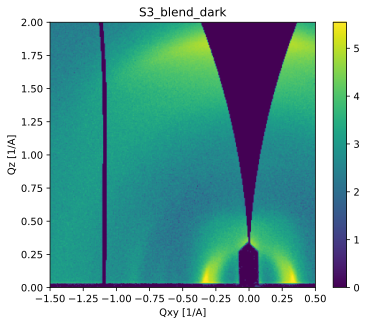

In [39]:
# Choose and show reduced image of sample:
sample = 'S3'
plot_reduced_image(sample, save=False)

In [40]:
# Show linecuts for sample in folder
data_list = sorted(linecutPath.glob(f'*{sample}_masked_*'))

# Print files name
for i, file in enumerate(data_list):
    print(i, file.name)

0 S3_masked_chi_-15to0_q_13E-2to30E-1.txt
1 S3_masked_chi_-30to-15_q_13E-2to30E-1.txt
2 S3_masked_chi_-45to-30_q_13E-2to30E-1.txt
3 S3_masked_chi_-60to-45_q_13E-2to30E-1.txt
4 S3_masked_chi_-75to-60_q_13E-2to30E-1.txt
5 S3_masked_chi_-90to-75_q_13E-2to30E-1.txt
6 S3_masked_chi_-90to0.txt


In [41]:
print(data_list[-1].name)
norm_slice = np.loadtxt(data_list[-1])
norm_slice.shape

S3_masked_chi_-90to0.txt


(420, 2)

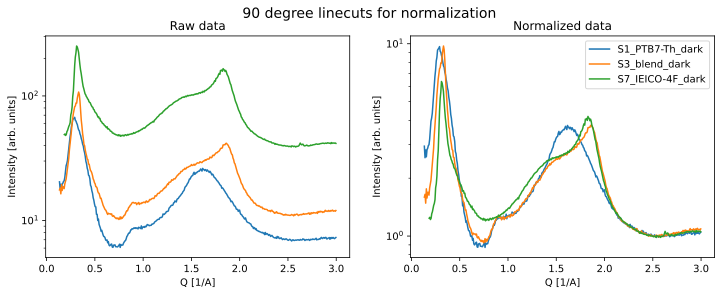

In [104]:
# Code for plotting all 90-deg un-normalized and normalized plots together

# Show linecuts for sample in folder
samples = ['S1', 'S3', 'S7']
data_list = []
for sample in samples:
    data_list.append(sorted(linecutPath.glob(f'*{sample}_masked_*-90to0*'))[0])

# # Print files name
# for i, file in enumerate(data_list):
#     print(i, file.name[:2])

    
# Load data into data_dictionary:
data_dict = {}
for data in data_list:
    name = data.name[:2]
    vars().__setitem__(name, np.loadtxt(data))
    data_dict[name] = vars()[name]

fig, (ax1, ax2) = plt.subplots(1,2)    
fig.suptitle('90 degree linecuts for normalization', size=14)
fig.set(size_inches=(12,4))

for sample in samples:
    q = data_dict[sample][:,0]
    I = data_dict[sample][:,1]
    
    norm_index = np.where(np.abs(q - 2.5) < 0.01)[0][-2]
    q_norm = q[norm_index]
    avgI = I[norm_index]
    I_normed = I/avgI
    
    
    ax1.plot(q, I, label=f'{sample}_{sample_dict[sample]}')
    ax1.set(title='Raw data', yscale='log', ylabel='Intensity [arb. units]', xlabel='Q [1/A]')
    
    ax2.plot(q, I_normed, label=f'{sample}_{sample_dict[sample]}')
    ax2.set(title='Normalized data', yscale='log', ylabel='Intensity [arb. units]', xlabel='Q [1/A]')
    
plt.legend()
plt.savefig(savePath.joinpath('90deg_cuts_raw_to_normalized.svg'))

In [10]:
# slice data list as needed for files you want to plot:
data_list = data_list[:-1]

# Print files name
for i, file in enumerate(data_list):
    print(i, file.name)

0 S3_masked_chi_-15to0_q_13E-2to30E-1.txt
1 S3_masked_chi_-30to-15_q_13E-2to30E-1.txt
2 S3_masked_chi_-45to-30_q_13E-2to30E-1.txt
3 S3_masked_chi_-60to-45_q_13E-2to30E-1.txt
4 S3_masked_chi_-75to-60_q_13E-2to30E-1.txt
5 S3_masked_chi_-90to-75_q_13E-2to30E-1.txt


In [11]:
# Import linecut data into 2 dictionaries (1 containing all data and 1 containing just most IP and OOP scans)
data_dict = {}
IP_OOP_dict = {}

for data in data_list:
    name = data.name[:-19]
    vars().__setitem__(name, np.loadtxt(data))
    data_dict[name] = vars()[name]
    if name[9:] == '_chi_-15to0' or name[9:] == '_chi_-90to-75':  # choose your most IP and OOP scans 
        IP_OOP_dict[name] = vars()[name]

display(data_dict.keys())
display(IP_OOP_dict.keys())

dict_keys(['S3_masked_chi_-15to0', 'S3_masked_chi_-30to-15', 'S3_masked_chi_-45to-30', 'S3_masked_chi_-60to-45', 'S3_masked_chi_-75to-60', 'S3_masked_chi_-90to-75'])

dict_keys(['S3_masked_chi_-15to0', 'S3_masked_chi_-90to-75'])

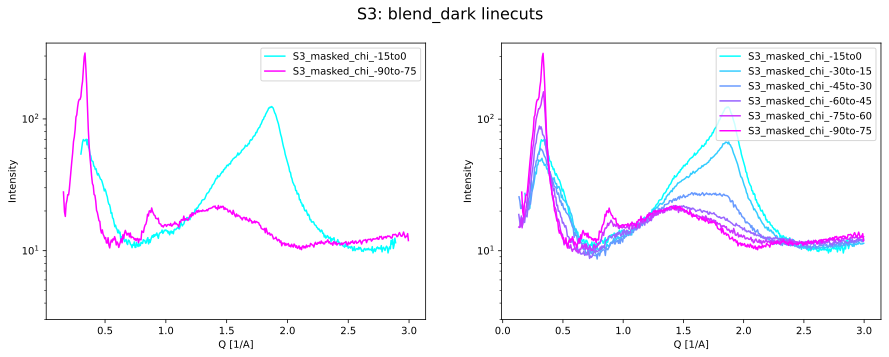

In [12]:
linecut_plotter(IP_OOP_dict, data_dict, sample, sample_dict, bot=3)

### Normalization:

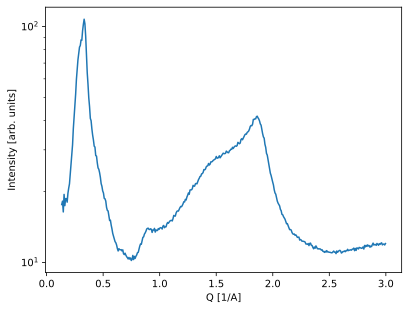

In [13]:
norm_q = norm_slice[:, 0]
norm_I = norm_slice[:, 1]
plt.semilogy(norm_q, norm_I)
plt.xlabel('Q [1/A]')
plt.ylabel('Intensity [arb. units]')
# plt.ylim(bottom=4)
plt.show()

In [14]:
norm_index = np.where(np.abs(norm_q - 2.5) < 0.01)[0][-2]
q_norm = norm_q[norm_index]
avgI = norm_I[norm_index]
print(f'Intensity: {avgI}')

Intensity: 11.034876823425293


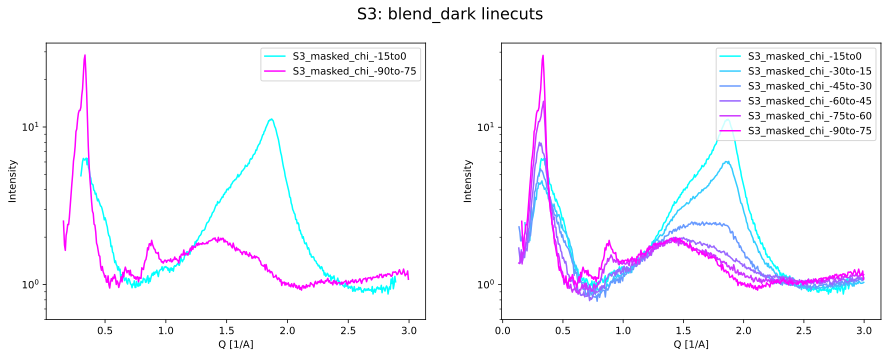

In [15]:
# Normalize: Create new normalized data dictionaries
normed_data_dict = {}
normed_IP_OOP_dict = {}

for key in data_dict:
    q = data_dict[key][:,0]
    I = data_dict[key][:,1]
    I_normed = I/avgI
    
    normed_data_dict[key] = np.vstack((q,I_normed)).T
    
    if key == f'{sample}_masked_chi_-15to0' or key == f'{sample}_masked_chi_-90to-75':
        normed_IP_OOP_dict[key] = np.vstack((q,I_normed)).T

# plot to check
linecut_plotter(dict1=normed_IP_OOP_dict, dict2=normed_data_dict, sample=sample, sample_dict=sample_dict, save=False, bot=6e-1)

In [474]:
# PTB7-Th IP linecut
sector = 'IP'
q_max = 2.2
q, I = linecut_data(sector, q_max)

# Set slope and intercept of background by drawing line through minimum point and where the data was normed
I_min = I.min()
q_min = q[np.where(I==I_min)[0][0]]
m = (1-I_min)/(q_norm-q_min)
intercept = I_min - m*q_min

# Define all models to include in fitting
# bkg_mod = LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params(intercept=intercept, slope=m)
bkg_mod = LinearModel(prefix='bkg_')
pars = bkg_mod.make_params(intercept=0.5, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = PseudoVoigtModel(prefix='pk1_')
pars += pk1_mod.guess(I, q, center=.25)

pk2_mod = PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(I, q, center=0.9)

pk3_mod = PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(I, q, center=1.4)

pk4_mod = PseudoVoigtModel(prefix='pk4_')
pars += pk4_mod.guess(I, q, center=1.7)


# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod + pk4_mod # + pk5_mod + pk6_mod


# Run fit and store all info in a ModelResult object
out = mod.fit(I, pars, x=q)

In [498]:
# PTB7-Th OOP linecut
sector = 'OOP'
q, I = linecut_data(sector)

# Set slope and intercept of background by drawing line through minimum point and where the data was normed
I_min = I.min()
q_min = q[np.where(I==I_min)[0][0]]
m = (1-I_min)/(q_norm-q_min)
intercept = I_min - m*q_min

# Define all models to include in fitting
# bkg_mod = LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params(intercept=intercept, slope=m)
bkg_mod = LinearModel(prefix='bkg_')
pars = bkg_mod.make_params(intercept=0.5, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = PseudoVoigtModel(prefix='pk1_')
pars += pk1_mod.guess(I, q, center=.4)

pk2_mod = PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(I, q, center=1.5)
pars['pk2_center'].set(min=1.4, max=1.6)
pars['pk2_sigma'].set(max=1)

pk3_mod = PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(I, q, center=1.7)
pars['pk3_center'].set(min=1.62, max=1.75)
pars['pk3_sigma'].set(max=1)


# pk4_mod = PseudoVoigtModel(prefix='pk4_')
# pars += pk4_mod.guess(I, q, center=1.7)

# pk5_mod = PseudoVoigtModel(prefix='pk5_')
# pars += pk5_mod.guess(I, q, center=1.6)

# pk6_mod = PseudoVoigtModel(prefix='pk6_')
# pars += pk6_mod.guess(I, q, center=2.25)


# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod #+ pk4_mod # + pk5_mod + pk6_mod


# Run fit and store all info in a ModelResult object
out = mod.fit(I, pars, x=q)

In [529]:
# S3 Blend IP linecut
sector = 'IP'
q_max = 2.1
q, I = linecut_data(sector, q_max)

# # Set slope and intercept of background by drawing line through minimum point and where the data was normed
# I_min = I.min()
# q_min = q[np.where(I==I_min)[0][0]]
# m = (1-I_min)/(q_norm-q_min)
# intercept = I_min - m*q_min


# Really just want straight line from norm point to *local* minimum around q=0.55?
I_min = I[np.where(np.abs(q-0.55)<2e-1)[0]].min()
q_min = q[np.where(I==I_min)[0][0]]
m = (1-I_min)/(q_norm-q_min)
intercept = I_min - m*q_min

# Define all models to include in fitting
bkg_mod = LinearModel(prefix='bkg_')
pars = bkg_mod.make_params(intercept=0.5, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = PseudoVoigtModel(prefix='pk1_')
pars += pk1_mod.guess(I, q, center=.28)
pars['pk1_amplitude'].set(min=0.5)

pk2_mod = PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(I, q, center=.35)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
pars['pk2_amplitude'].set(min=0.5)

pk3_mod = PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(I, q, center=0.7)
# pars['pk3_center'].set(min=1.3, max=1.4)
# pars['pk3_sigma'].set(max=0.5)
pars['pk3_amplitude'].set(min=1e-2)

pk4_mod = PseudoVoigtModel(prefix='pk4_')
pars += pk4_mod.guess(I, q, center=0.9)
pars['pk4_amplitude'].set(min=1e-2)
# pars['pk4_center'].set(max=1.72)

pk5_mod = PseudoVoigtModel(prefix='pk5_')
pars += pk5_mod.guess(I, q, center=1.35)
pars['pk5_amplitude'].set(min=1e-2)

pk6_mod = PseudoVoigtModel(prefix='pk6_')
pars += pk6_mod.guess(I, q, center=1.7)
pars['pk6_amplitude'].set(min=1e-2)
pars['pk6_sigma'].set(max=0.5)

# pka_mod = PseudoVoigtModel(prefix='pka_')
# pars += pka_mod.guess(I, q, center=0.8)
# pars['pka_center'].set(min=0.78)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod + pk4_mod + pk5_mod + pk6_mod


# Run fit and store all info in a ModelResult object
out = mod.fit(I, pars, x=q)

In [34]:
# S3 Blend OOP linecut
sector = 'OOP'
q_max = 2.6
q, I = linecut_data(sector, q_max)

# Set slope and intercept of background by drawing line through minimum point and where the data was normed
I_min = I.min()
q_min = q[np.where(I==I_min)[0][0]]
m = (1-I_min)/(q_norm-q_min)
intercept = I_min - m*q_min

# Define all models to include in fitting
# bkg_mod = LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params(intercept=intercept, slope=m)
bkg_mod = LinearModel(prefix='bkg_')
pars = bkg_mod.make_params(intercept=0.5, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = PseudoVoigtModel(prefix='pk1_')
pars += pk1_mod.guess(I, q, center=.4)
pars['pk1_amplitude'].set(min=1e-2)
pars['pk1_center'].set(min=0.25,max=0.42)
pars['pk1_sigma'].set(max=1)

# pk2_mod = PseudoVoigtModel(prefix='pk2_')
# pars += pk2_mod.guess(I, q, center=0.45)
# pars['pk2_amplitude'].set(min=2e-2)
# pars['pk2_center'].set(min=0.4, max=0.5)
# pars['pk2_sigma'].set(max=0.7)
# # pars['pk2_center'].set(min=1.4, max=1.6)
# # pars['pk2_sigma'].set(max=1)

pk2_mod = PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(I, q, center=1.5)
pars['pk2_amplitude'].set(min=1e-2)
pars['pk2_center'].set(min=1.3, max=1.6)
pars['pk2_sigma'].set(max=1)
# pars['pk2_center'].set(min=1.62, max=1.75)
# pars['pk2_sigma'].set(max=1)


pk3_mod = PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(I, q, center=1.8)
pars['pk3_amplitude'].set(min=1e-2)
pars['pk3_center'].set(min=1.62, max=1.9)
pars['pk3_sigma'].set(max=1)

# pk5_mod = PseudoVoigtModel(prefix='pk5_')
# pars += pk5_mod.guess(I, q, center=1.6)

# pk6_mod = PseudoVoigtModel(prefix='pk6_')
# pars += pk6_mod.guess(I, q, center=2.25)


# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod # + pk5_mod + pk6_mod


# Run fit and store all info in a ModelResult object
out = mod.fit(I, pars, x=q)

In [455]:
# IEICO-4F IP linecut
sector = 'IP'
q_max = 2
q, I = linecut_data(sector, q_max)

# # Set slope and intercept of background by drawing line through minimum point and where the data was normed
# I_min = I.min()
# q_min = q[np.where(I==I_min)[0][0]]
# m = (1-I_min)/(q_norm-q_min)
# intercept = I_min - m*q_min


# Really just want straight line from norm point to *local* minimum around q=0.55?
I_min = I[np.where(np.abs(q-0.55)<2e-1)[0]].min()
q_min = q[np.where(I==I_min)[0][0]]
m = (1-I_min)/(q_norm-q_min)
intercept = I_min - m*q_min

# Define all models to include in fitting
bkg_mod = LinearModel(prefix='bkg_')
pars = bkg_mod.make_params(intercept=0.5, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = PseudoVoigtModel(prefix='pk1_')
pars += pk1_mod.guess(I, q, center=.4)

pk2_mod = PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(I, q, center=.6)
pars['pk2_center'].set(max = 0.62, min = 0.58)
pars['pk2_sigma'].set(max = 0.03)
pars['pk2_amplitude'].set(min=2e-2)

pka_mod = PseudoVoigtModel(prefix='pka_')
pars += pka_mod.guess(I, q, center=0.8)
pars['pka_center'].set(min=0.78)

pk3_mod = PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(I, q, center=1.35)
# pars['pk3_center'].set(min=1.3, max=1.4)
# pars['pk3_sigma'].set(max=0.5)
pars['pk3_amplitude'].set(min=1e-2)

pk4_mod = PseudoVoigtModel(prefix='pk4_')
pars += pk4_mod.guess(I, q, center=1.7)
pars['pk4_amplitude'].set(min=1e-2)
# pars['pk4_center'].set(max=1.72)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod + pk4_mod + pka_mod


# Run fit and store all info in a ModelResult object
out = mod.fit(I, pars, x=q)

In [555]:
# IEICO-4F OOP linecut
sector = 'OOP'
q, I = linecut_data(sector)

# Set slope and intercept of background by drawing line through minimum point and where the data was normed
I_min = I.min()
q_min = q[np.where(I==I_min)[0][0]]
m = (1-I_min)/(q_norm-q_min)
intercept = I_min - m*q_min

# Define all models to include in fitting
# bkg_mod = LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params(intercept=intercept, slope=m)

bkg_mod = LinearModel(prefix='bkg_')
pars = bkg_mod.make_params(intercept=0.5, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

exp_mod = ExponentialModel(prefix='exp_')
pars += exp_mod.guess(I[:60], q[:60])

pk1_mod = PseudoVoigtModel(prefix='pk1_')
pars += pk1_mod.guess(I, q, center=1.5)

pk2_mod = PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(I, q, center=1.9)


# Combine into full model
mod = bkg_mod + exp_mod + pk1_mod + pk2_mod # + pk3_mod + pk4_mod # + pk5_mod + pk6_mod


# Run fit and store all info in a ModelResult object
out = mod.fit(I, pars, x=q)

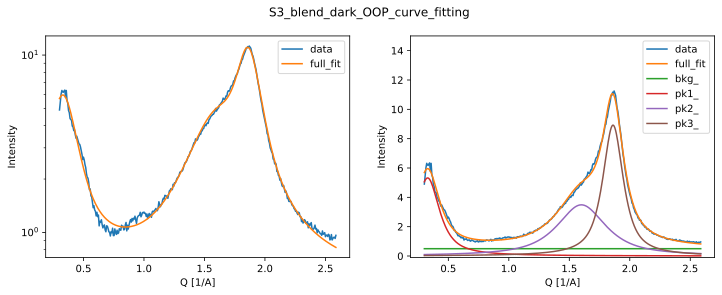

{'pk3_amplitude': 2.6957894337203596,
 'pk3_center': 1.8613689519754997,
 'pk3_sigma': 0.10142554518714525,
 'pk3_fraction': 0.8846128556501744,
 'pk2_amplitude': 2.5188060573025943,
 'pk2_center': 1.5999999997585914,
 'pk2_sigma': 0.24196926721616285,
 'pk2_fraction': 0.8883398073876658,
 'pk1_amplitude': 1.8663957263617805,
 'pk1_center': 0.3289794255627728,
 'pk1_sigma': 0.11688471735171208,
 'pk1_fraction': 0.9008844499090085,
 'bkg_slope': 0,
 'bkg_intercept': 0.5}

In [35]:
fit_plotter(q, I, out, top=15)
display(out.best_values)

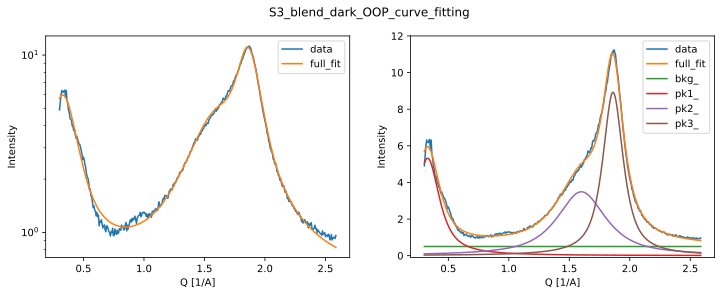

In [37]:
fit_plotter(q, I, out, top=12, save_plot=True, save_data=True, save_peaks=True)

[[Model]]
    (Model(step, prefix='step_', form='erf') + Model(linear, prefix='line_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 201
    # variables        = 5
    chi-square         = 593.709622
    reduced chi-square = 3.02913072
    Akaike info crit   = 227.700173
    Bayesian info crit = 244.216698
[[Variables]]
    line_slope:      1.87164655 +/- 0.09318713 (4.98%) (init = 0)
    line_intercept:  12.0964833 +/- 0.27606235 (2.28%) (init = 11.58574)
    step_amplitude:  112.858376 +/- 0.65392948 (0.58%) (init = 134.7378)
    step_center:     3.13494792 +/- 0.00516615 (0.16%) (init = 2.5)
    step_sigma:      0.67392841 +/- 0.01091168 (1.62%) (init = 1.428571)
[[Correlations]] (unreported correlations are < 0.100)
    C(line_slope, step_amplitude)     = -0.879
    C(step_amplitude, step_sigma)     = 0.564
    C(line_slope, step_sigma)         = -0.457
    C(line_intercept, step_center)    = 0.427
    C(line_slope, line_i

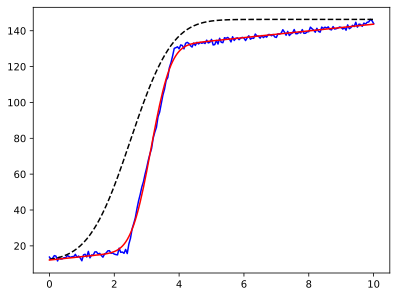

In [175]:
#!/usr/bin/env python

# <examples/doc_builtinmodels_stepmodel.py>
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import LinearModel, StepModel

x = np.linspace(0, 10, 201)
y = np.ones_like(x)
y[:48] = 0.0
y[48:77] = np.arange(77-48)/(77.0-48)
np.random.seed(0)
y = 110.2 * (y + 9e-3*np.random.randn(len(x))) + 12.0 + 2.22*x

step_mod = StepModel(form='erf', prefix='step_')
line_mod = LinearModel(prefix='line_')

pars = line_mod.make_params(intercept=y.min(), slope=0)
pars += step_mod.guess(y, x=x, center=2.5)

mod = step_mod + line_mod
out = mod.fit(y, pars, x=x)

print(out.fit_report())

plt.plot(x, y, 'b')
plt.plot(x, out.init_fit, 'k--')
plt.plot(x, out.best_fit, 'r-')
plt.show()
# <end examples/doc_builtinmodels_stepmodel.py>

In [ ]:
# def run_fit(*pks, **kwargs):
#     """
#     pks entered as tuples: (center, center_range, min_amp, max_sigma)
#     kwargs: must include q, I, and bkg_height
#     """
#     # for pk in pks:
#     #     print(pk)
#     # print(kwargs['bkg_height'])
    
#     q = kwargs['q']
#     I = kwargs['I']
#     b = kwargs['bkg_height']
    
    
#     bkg_mod = LinearModel(prefix='bkg_')
#     pars = bkg_mod.make_params(intercept=b, slope=0)
#     pars['bkg_intercept'].set(vary=False)
#     pars['bkg_slope'].set(vary=False)
    
#     for i, pk in enumerate(pks):
#         pk_mod = PseudoVoigtModel(prefix=f'pk{i+1}_')
#         pars += pk_mod.guess(I, q, center=pk[0])
#         if len(pk) >= 2:
#             pars[f'pk{i+1}_center'].set(max=pk[0])
    
    
    
#     # print(pks[0][0])
#     return pars
    

In [373]:
# pk1 = (0.4,)
# pk2 = (0.6, 0.02, 2e-2, 0.03)
# pk3 = (1.35, 0.1, 1e-2)
# pk4 = (1.7, 0.02, 1e-2)

# run_fit(pk1, pk2, pk3, q=q, I=I, bkg_height=0.5)